# Assumptions on System Constraints
1. The antenna is limited to a size of .3 m x 2 m to ease mechanical feasibility
2. The peak power is limited to 300W. Rationale: <1/3 of Synspective's StriX and 1/ of a NovaSAR phase center panel i.e. should  be feasible with COTS distributed PA e.g. using nine TGA2312-FL Qorvo GaN 60 W PAs.
3. L + F (losses and noise figure) = 10dB should be conservative enough.
4. The bandwidth is limited to 200 MHz i.e. 2/3 of StriX or ICEYE.
5. The orbital height is 500 km LEO


In [1]:
la = 2  # m
wa = .3  # m
losses = 10  # dB
h = 500e3  # m

# Design Choices
1. We choose a target resolution of 3 m$^2$ (it seemed a good trade-off from previous analysis)
2. We choose a looking angle of 30$^\circ$ (it is in the range of looking angles considered by DLR for the ship characterization and should provide strong enough returns).
3. The duty cycle is set to be 1/4 (same of StriX) yielding an average power of 125 W.
4. The acquisition mode is an azimuthally-ambiguous strip-map mode with full doppler bandwidth processed (hig resolution).


In [2]:
ares = 3  # m2
theta = 28  # deg
pavg = .25 * 300  # W
pavg

75.0

# System Design
We follow the design procedure for ambiguous detection proposed by DLR in
**"A Low-Power, Ambiguous Synthetic Aperture Radar Concept for Continuous Ship Monitoring"**

## Bandwidth Choice
to satisfy the target resolution requirement at an incidence angle of 30$^\circ$, the bandwidth is found from
\begin{equation}
    B_n = \dfrac{c L_a}{4 \sin{\Theta} A_{res}}
\end{equation}
$L_a$ = antenna length, c = light speed, $\Theta$ = incidence angle, $A_{res}$ = Resolution area.

In [3]:
import numpy as np


def find_bandwidth(La, Theta, Ares, c=299792458):
    """
    design equation for bandwidth selection
    :param La: Antenna length
    :param Theta: incidence angle
    :param Ares: Resolution Area
    :return: Bandwidth
    """
    return c * La / (4 * np.sin(Theta * np.pi / 180) * Ares)


B = find_bandwidth(la, theta, ares)
print("B_n = ", B / 1e6, " MHz")

B_n =  106.42904411540279  MHz


## PRF initial choice
the PRF is chosen to match the 3 dB elevation beam-width and aligned to center the swath between pulses
1. we start finding the approximated value for the beam extremes elevation angles:
    \begin{equation}
        \begin{split}
        \theta_1 = \theta - \dfrac{\lambda}{2 W_a}\\
        \theta_2 = \theta + \dfrac{\lambda}{2 W_a}
        \end{split}
    \end{equation}
2. we can use this approximate incidence angles to find the two slant range points.
    This can be done with the function "range_from_theta(theta)" that numerically
    inverts the slant range for an incidence angle on a point over a spherical earth.
    we'll then have:
    \begin{equation}
        \begin{split}
        R_1 = \text{range_from_theta}(\theta_1)\\
        R_2 = \text{range_from_theta}(\theta_2)
        \end{split}
    \end{equation}
3. The Pulse Repetition Interval ($1/\text{PRF}$) initial value is then found to match the slant range delta roundtrip delay
    \begin{equation}
        \text{PRI} = \dfrac{ 2 (R_2 - R_1) }{c}
    \end{equation}
4. To "center" the pulse in the received signal, the near end slant range round trip delay must be an integer multiple of the PRI.
    We therefore need to find the impulse order closest to the one associated to $R_1$ and recompute $R_1$, $R_2$, and PRI to the nearest *legal* value.
    \begin{equation}
        n = \text{floor}\left(\dfrac{2 R }{c \text{PRI}}\right)
    \end{equation} Where R is the average $(R_2+R_1)/2$ slant range

5. a new PRI is chosen to place the beam center point at the center of the scene:
    \begin{equation}
        \text{PRI}' = \dfrac{2 R}{(n + 0.5) c}
    \end{equation}
6. From the new PRI we find the corrected $R_1$, $R_2$ and slant range swath width
       \begin{equation}
        \begin{split}
        R_1' = n \text{PRI} c /2\\
        R_2' = (n+1) \text{PRI} c /2\\
        \end{split}
    \end{equation}
7. From the corrected slant ranges we can find the ground NE and FE ranges and swath width

in a concise function:

In [4]:
from design_functions import *

freq = 10e9
PRI_1, ground_swath = pri_max_swath(theta, wa, freq=freq, nefe=True)
PRI_1, slant_swath = pri_max_swath(theta, wa, freq=freq, nefe=True, slant=True)
print("corrected PRI = ", PRI_1)
print("corrected PRF = ", 1 / PRI_1)
print("corrected ground swath = ", ground_swath, ground_swath[1] - ground_swath[0])
# broadside ground range
r, rg0 = range_from_theta(theta, h)
print("antenna broadside ground range: ", rg0)

corrected PRI =  0.00018273611803546779
corrected PRF =  5472.37191394154
corrected ground swath =  [215578.71514828 273869.90604403] 58291.1908957407
antenna broadside ground range:  244082.5289980333


## PRF and looking angle choice limited by nadir return
The widest-possible swath PRF choice of above only depends on the antenna width and looking angle. If we want to minimize the influence of nadir return we have to choose theta so that the nadir appears at the beginning or at the end of the swath.

The enveloped slant range of the nadir return will be:
\begin{equation}
    R_{nadir} = H \% \left(\dfrac{c\ \text{PRI}}{2}\right) + n \left( \frac{c\ \text{PRI}}{2}\right)
\end{equation}
The term $  H \% \left(\dfrac{c\ \text{PRI}}{2}\right)$ needs to be zero to hide the nadir return "under" the transmit event.


Instead of slant range we can use the Ground range, and instead of the PRI we can use the PRF to produce a timing diagram.
We can also look at the transmit and receive events wrapped positions in range as function of the PRF.

The position of the trasmit event in slant range is bounded by:
\begin{equation}
    R_{transmit} = n \left( \dfrac{c\ \text{PRI}}{2} \right) \pm \left( \dfrac{c\ \text{PRI}\ \delta }{2} \right)
\end{equation}
wiht $\delta$ = duty cycle

### Timing diagram
the output of the above can be displayed using a timing diagram

C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:43: RuntimeWarning: invalid value encountered in arccos
  beta = arccos(((re + h) ** 2 - re ** 2 + rs ** 2) / (2 * (re + h) * rs))
C:\Users\smen851\PycharmProjects\design-baseline\design_functions.py:44: RuntimeWarning: invalid value encountered in arccos
  alpha = arccos(((re + h) ** 2 + re ** 2 - rs ** 2) / (2 * (re + h) * re))


(2736.18595697077, 10944.74382788308)

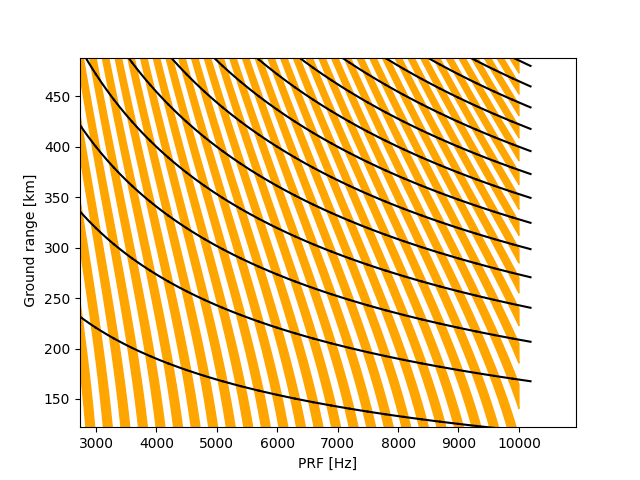

In [5]:
import matplotlib.pyplot as plt
import matplotlib
from timing_diagram import time_diagram_plotter

matplotlib.use('Qt5Agg')
%matplotlib widget

prf = np.linspace(1, 10e3, 10000)

# plotting
fig, ax = plt.subplots(1)

# 1/4 duty cycle
time_diagram_plotter(ax, prf, 0.25, h)

ax.set_xlabel('PRF [Hz]')
ax.set_ylabel(' Ground range [km]')
ax.set_ylim(rg0 / 2000, rg0 / 1000 * 2)
ax.set_xlim(1 / PRI_1 / 2, 1 / PRI_1 * 2)

### Current solution on timing diagram

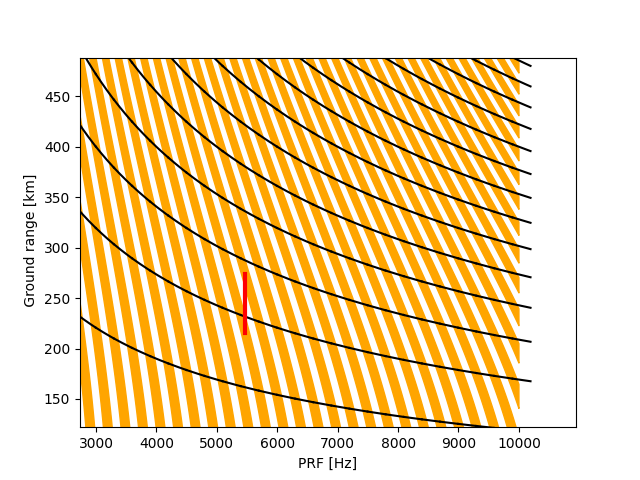

In [6]:
prff = np.ones_like(ground_swath) / PRI_1

ax.plot(prff, ground_swath / 1000, 'r', linewidth=3)
plt.show()

### Lock to closest valid looking angle:
The incidence angle and PRI can be further update to "lock" the swath line to the closest valid point in the timing diagram (to avoid nadir returns).\
The incidence angle, the swath width and the PRI will be slightly modified, but still close to the original setting. The procedure ivolves 3 steps:
1. Find the closest valid PRI ie the closest exact divisor for the nadir time delay

    a. first we find the order
        \begin{equation}
            m = \text{round}\left( \dfrac{2\ h}{c\ \text{PRI}} \right)
        \end{equation}

    b. The closest valid PRI point is therefore
        \begin{equation}
            \text{PRI}' = \dfrac{h\ 2}{m\ c}
        \end{equation}
2. Then we find the closest **slant** near end valid range on the PRI line, i.e. the closest near end time delay multiple of an impulse period
     a. First we find the order
        \begin{equation}
            n = \text{round}\left( \dfrac{2 R_{ne}}{\text{PRI}'\ c} \right)
        \end{equation}
     b. Then we find the closest range point
        \begin{equation}
             R_{ne}' = \dfrac{n\ \text{PRI}'\ c}{2}
        \end{equation}
     c. And the corresponding far end valid point
        \begin{equation}
             R_{fe}' = \dfrac{(n+1)\ \text{PRI}'\ c}{2}
        \end{equation}
3. The incidence angle can be then deducted by the slant near end and far end ranges
        \begin{equation}
            \theta' = \dfrac{\theta'_{ne} + \theta'_{fe}}{2}
        \end{equation}

In a coincise function

In [7]:
from design_functions import *

#test
Theta_1, PRI_2, ground_swath_2 = closest_nadir_null(PRI_1, slant_swath[0], h)

In [8]:
print("corrected theta = ", Theta_1)
print("corrected PRI = ", PRI_2)
print("corrected PRF = ", 1 / PRI_2)
print("corrected ground swath = ", ground_swath_2, ground_swath_2[-1] - ground_swath_2[0])
# broadside ground range
r, rg1 = range_from_theta(Theta_1, h)
print("antenna broadside ground range: ", rg0)

corrected theta =  29.619355820496427
corrected PRI =  0.0001853133862211956
corrected PRF =  5396.264244
corrected ground swath =  [233196.68252408 289348.73240482] 56152.04988073808
antenna broadside ground range:  244082.5289980333


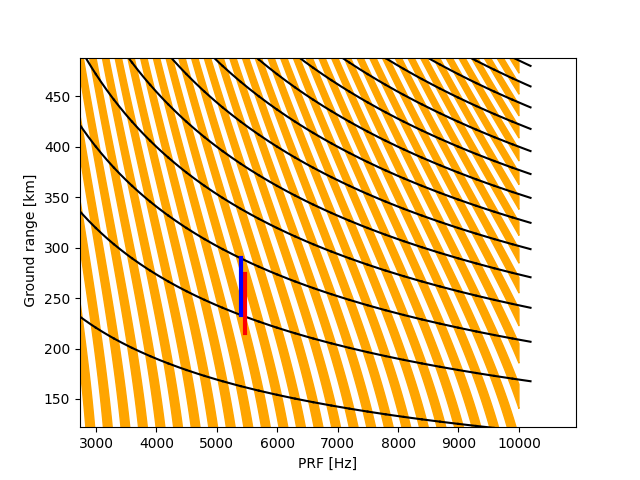

In [9]:

prff = np.abs(np.ones_like(ground_swath_2) / PRI_2)
ax.plot(prff, ground_swath_2 / 1000, 'b', linewidth=3)
plt.show()

# Evaluation of useful swath after duty cycle
The near end and far end usable swath slant range is given by
    \begin{equation}
        \begin{split}
            R_{ne}' = R_{ne} + \delta \dfrac{\text{PRI} c}{2}\\
            R_{fe}' = R_{fe} - \delta \dfrac{\text{PRI} c}{2}
        \end{split}
    \end{equation}

In [10]:
delta = 0.25
c = 299792458
slant_range = range_ground_to_slant(ground_swath_2)
blindr = np.array([delta * PRI_2 * c / 2, - delta * PRI_2 * c / 2])
slant_range_inner = slant_range + blindr
print("usable slant range: ", slant_range_inner)
ground_swath_inner, theta = range_slant_to_ground(slant_range_inner)
print("usable ground swath: ", ground_swath_inner, ground_swath_inner[-1] - ground_swath_inner[0])

usable slant range:  [562499.99999999 576388.88888889]
usable ground swath:  [248156.5603777  276138.85720795] 27982.296830248146


# Detection performance
According to *"A low power, Ambiguous Synthetic Aperture Radar Concept for Continuous Ship Monitoring"* by N Ustalli et all.\
The probability of detection and probability of false alarm Are related to the Noise Equivalent Sigma Zero via the following equations:

\begin{equation}
    \begin{split}
        P_{fa} &= \dfrac{A_{ship}}{A_{cell}} \exp\left(-\dfrac{T}{NESZ}\right)\\
        P_{d} &\approx 1 - \left[\dfrac{1}{2} + \dfrac{1}{2} \text{erf}\left( \dfrac{\ln(T) - \beta}{\sqrt{2V}} \right)\right]^ {\dfrac{A_{ship}}{A_{cell}}}
    \end{split}
\end{equation}

$\beta$ and $V$ are respectively the norm and variance of a log normal distribution associated to the intensity distribution of ships pixels. fitted values for different ship classes can be found in the article.\
The Probability of false alarm can be set as the number of false alarms over the total scene of interest:
\begin{equation}
    P_{fa} = \dfrac{N_{fa's}\ A_{ship}}{A_{surveillance}}
\end{equation}
From the above is clear that once set a probability of false alarm, the Probability of detection only depends on the NESZ. \
Performance evaluation then involves 2 steps:
1. find the NESZ associated to beam-pattern and problem geometry
2. compute $P_d (NESZ)|_{P_{fa}}$

## step 1 Find the NESZ
- Find the inital NESZ
- recenter the beam to give maximum performances
- recompute the NESZ with the corrected looking angle

In [11]:
# 1 incidence angles vector
from radartools.farField import UniformAperture
from spherical_earth_geometry_radar import *

ran = range_ground_to_slant(ground_swath_2, h)
rg, theta_i = range_slant_to_ground(ran, h)
print(theta_i * 180 / np.pi)
incidence = np.linspace(theta_i[0], theta_i[-1], 31)
# 2 radar object
radGeo = RadarGeometry()
print(Theta_1)
beta = incidence_angle_to_looking_angle(Theta_1 * np.pi / 180)
radGeo.set_rotation(beta, 0, 0)
radGeo.set_initial_position(0, 0, h)
v_s = radGeo.orbital_speed()
radGeo.set_speed(v_s)
# 3 aperture object
uniap = UniformAperture(la, wa, freq)
wavel = c/freq
print(v_s)
# 4 SNR core
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)


[26.9103312  32.32838044]
29.619355820496427
[7612.68398988]


C:\Users\smen851\PycharmProjects\design-baseline\radartools\farField.py:149: RuntimeWarning: invalid value encountered in divide
  f = sin(kx * self.L / 2) / (kx * self.L / 2) * sin(ky * self.W / 2) / (ky * self.W / 2) * self.L * self.W


In [12]:
# usable range limits to plot
t1 = theta[0]
t2 = theta[-1]
c = np.array([SNR_core.min(), SNR_core.max()])


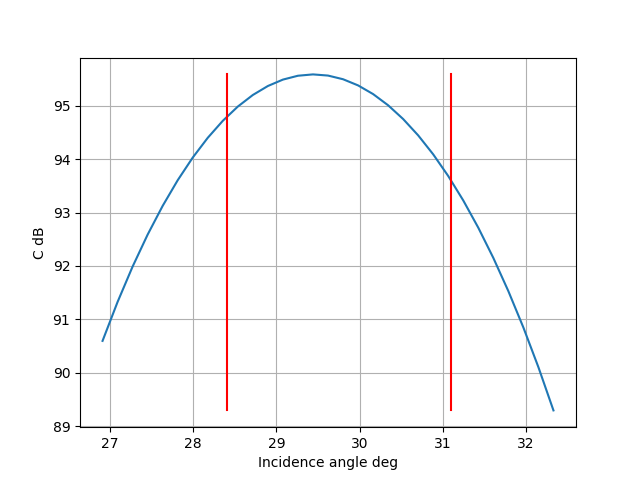

In [13]:
# plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence*180/np.pi, 10 * np.log10(SNR_core))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('C dB')
ax.grid()

ax.plot(np.ones_like(c) * t1 * 180 / np.pi, 10 * np.log10(c), 'r')
ax.plot(np.ones_like(c) * t2 * 180 / np.pi, 10 * np.log10(c), 'r')
#ax.set_xlim(235, 290)
#ax.set_ylim(90, 99)

### Recentering the beam
1. Error function defined as C(t2)-C(t1) i.e. difference between ne and fe
2. optimization of error function using as only variable the radar looking angle

In [14]:
e0 = snr_error(beta, t1, t2, radGeo, uniap)
print(e0)

-725305911.4649825


In [15]:
# optimization
from scipy.optimize import fsolve
beta_opt = fsolve(lambda b: snr_error(b, t1, t2, radGeo, uniap), beta, maxfev=1000)
beta_opt*180/np.pi

array([27.5469684])

### recentered beam

In [16]:
radGeo.set_rotation(beta_opt, 0, 0)
# 4 SNR core
SNR_core, daz = core_snr_spherical(radGeo, uniap, incidence, wavel, v_s, h)

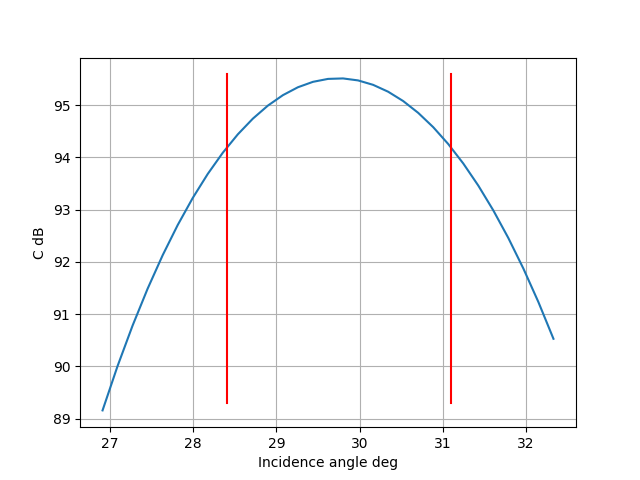

In [17]:
# plotting
fig, ax = plt.subplots(1)
rs, rg = range_from_theta(incidence * 180 / np.pi, h)
ax.plot(incidence*180/np.pi, 10 * np.log10(SNR_core))
ax.set_xlabel('Incidence angle deg')
ax.set_ylabel('C dB')
ax.grid()

ax.plot(np.ones_like(c) * t1 * 180 / np.pi, 10 * np.log10(c), 'r')
ax.plot(np.ones_like(c) * t2 * 180 / np.pi, 10 * np.log10(c), 'r')
#ax.set_xlim(235, 290)
#ax.set_ylim(90, 99)

## Parametrized NESZ
\begin{equation}
    NESZ = \dfrac{F\ L \ T_a\ B_n}{C\ P_{av}}
\end{equation}

# Ambiguities

In [18]:
# for RASR and AASR, however is better to have a spherical earth. Omega-K?